In [1]:
from env.dr_env import DemandResponseEnv
from dra.ppo_agent import PPOAgent
import numpy as np
import torch

In [2]:
data_path = "../data/synthetic"
env = DemandResponseEnv(data_path)

obs_dim = len(env.reset())
act_dim = 1  # Since PPO gives a scalar price signal

agent = PPOAgent(obs_dim, act_dim)

In [10]:
num_episodes = 2500

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, logprob = agent.select_action(obs)

        # Broadcast action to all houses if needed
        if np.isscalar(action):
            action = np.full(env.n_houses, action)

        next_obs, reward, done, info = env.step(action)

        agent.store_transition(obs, action, logprob, reward, done)

        obs = next_obs
        total_reward += reward

    agent.train()

    print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}")

[PPO Update] Epoch 1/10 actor_loss=0.3003, critic_loss=84996.2812, entropy=5.9185
[PPO Update] Epoch 2/10 actor_loss=0.3003, critic_loss=84084.8828, entropy=5.9188
[PPO Update] Epoch 3/10 actor_loss=0.3003, critic_loss=83148.9766, entropy=5.9191
[PPO Update] Epoch 4/10 actor_loss=0.3003, critic_loss=82193.0234, entropy=5.9194
[PPO Update] Epoch 5/10 actor_loss=0.3003, critic_loss=81221.3750, entropy=5.9197
[PPO Update] Epoch 6/10 actor_loss=0.3003, critic_loss=80238.9922, entropy=5.9200
[PPO Update] Epoch 7/10 actor_loss=0.3003, critic_loss=79249.3984, entropy=5.9203
[PPO Update] Epoch 8/10 actor_loss=0.3003, critic_loss=78254.0312, entropy=5.9206
[PPO Update] Epoch 9/10 actor_loss=0.3003, critic_loss=77255.5625, entropy=5.9209
[PPO Update] Epoch 10/10 actor_loss=0.3003, critic_loss=76255.7344, entropy=5.9212
Episode 1, Total Reward: -1214.39
[PPO Update] Epoch 1/10 actor_loss=0.3246, critic_loss=26668.4004, entropy=5.9215
[PPO Update] Epoch 2/10 actor_loss=0.3246, critic_loss=27155.22

In [11]:
# Quick diagnostics to run where you have env and agent
import numpy as np

obs = env.reset()
done = False
step = 0
per_step = []
infos = []
while not done and step < 200:
    action, lp = agent.select_action(obs)   # same selection used in training
    next_obs, reward, done, info = env.step(action)
    per_step.append(reward)
    infos.append(info)
    obs = next_obs
    step += 1

per_step_arr = np.array(per_step, dtype=object)  # keep original types
print("Steps:", step)
print("Reward types:", set(type(r) for r in per_step[:5]))
# If rewards are arrays, show their shapes/sizes
for i, r in enumerate(per_step[:10]):
    if isinstance(r, (list, tuple, np.ndarray)):
        print(f"step {i} reward is array, shape/len:", np.shape(r), "sample:", np.array(r).flatten()[:5])
print("Per-step stats: min, max, mean, sum:", 
      float(np.min([float(np.array(r).sum()) for r in per_step_arr])),
      float(np.max([float(np.array(r).sum()) for r in per_step_arr])),
      float(np.mean([float(np.array(r).sum()) for r in per_step_arr])),
      float(sum([float(np.array(r).sum()) for r in per_step_arr])))
print("First 20 per-step rewards:", per_step[:20])
print("Sample info dicts (first 5):", infos[:5])

Steps: 96
Reward types: {<class 'numpy.float64'>}
Per-step stats: min, max, mean, sum: -124095.07897745183 120036.53093260093 -9845.267967088495 -945145.7248404955
First 20 per-step rewards: [np.float64(-2.39271183181415), np.float64(-35013.69546847761), np.float64(3396.286566626223), np.float64(8684.691898805451), np.float64(-23024.07370906533), np.float64(66525.0786749474), np.float64(-75639.57542858442), np.float64(-32759.24161036904), np.float64(-54750.80220714773), np.float64(83362.96702377804), np.float64(17462.20139593577), np.float64(-2609.706371973916), np.float64(-2458.167048527156), np.float64(20151.825655252123), np.float64(96843.79454956786), np.float64(-52031.08485697626), np.float64(-80511.4407476493), np.float64(-16621.249266543375), np.float64(-61717.885602256654), np.float64(-92546.33998637715)]
Sample info dicts (first 5): [{'price': np.float32(111392.08), 'total_power': 0.0, 'avg_indoor_temp': 18.970924531822217}, {'price': np.float32(157187.58), 'total_power': 24.5

In [4]:
# Store evaluation results
eval_rewards = []
eval_temperatures = []
eval_power_used = []
eval_prices = []

obs = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = agent.select_action(obs)

    if np.isscalar(action):
        action = np.full(env.n_houses, action)

    obs, reward, done, info = env.step(action)

    # Collect info
    total_reward += reward
    eval_rewards.append(reward)
    eval_temperatures.append(info["avg_indoor_temp"])
    eval_power_used.append(info["total_power"])
    eval_prices.append(info["price"])

print(f"Evaluation complete — Total Reward: {total_reward:.2f}")

Evaluation complete — Total Reward: -1428.26


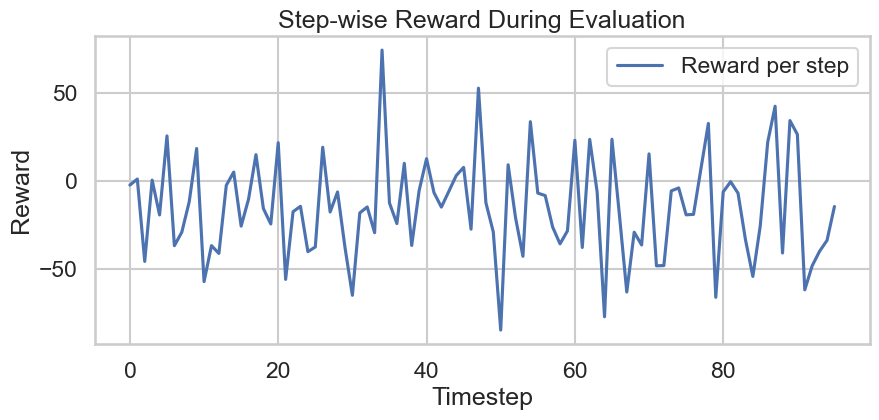

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(eval_rewards, label='Reward per step')
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Step-wise Reward During Evaluation")
plt.grid(True)
plt.legend()
plt.show()

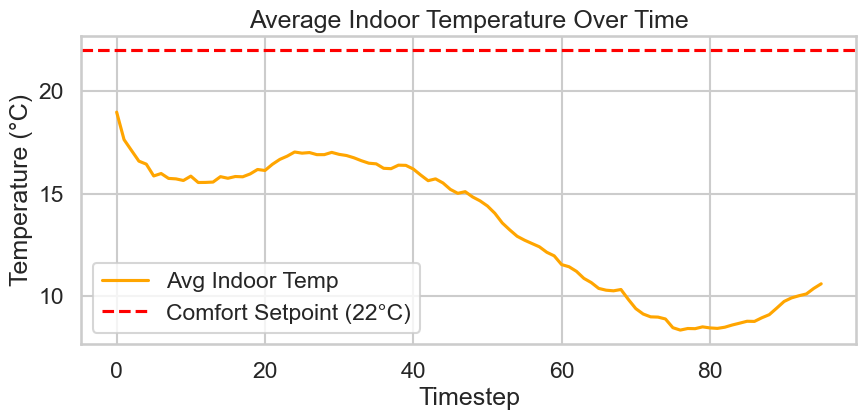

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(eval_temperatures, label='Avg Indoor Temp', color='orange')
plt.axhline(22, color='red', linestyle='--', label='Comfort Setpoint (22°C)')
plt.xlabel("Timestep")
plt.ylabel("Temperature (°C)")
plt.title("Average Indoor Temperature Over Time")
plt.grid(True)
plt.legend()
plt.show()

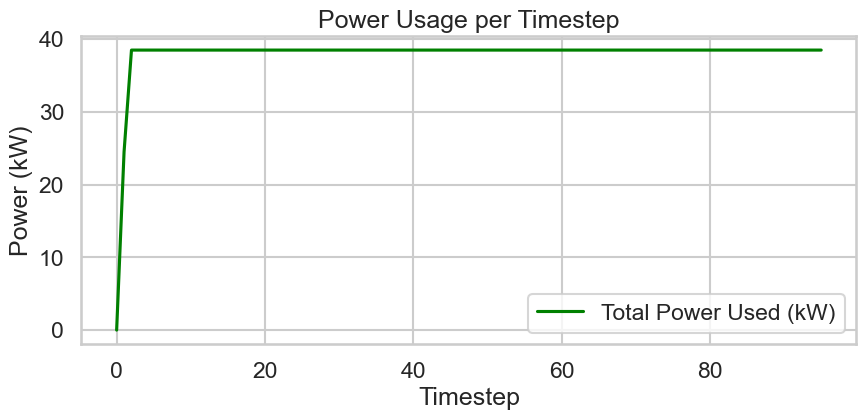

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(eval_power_used, label='Total Power Used (kW)', color='green')
plt.xlabel("Timestep")
plt.ylabel("Power (kW)")
plt.title("Power Usage per Timestep")
plt.grid(True)
plt.legend()
plt.show()

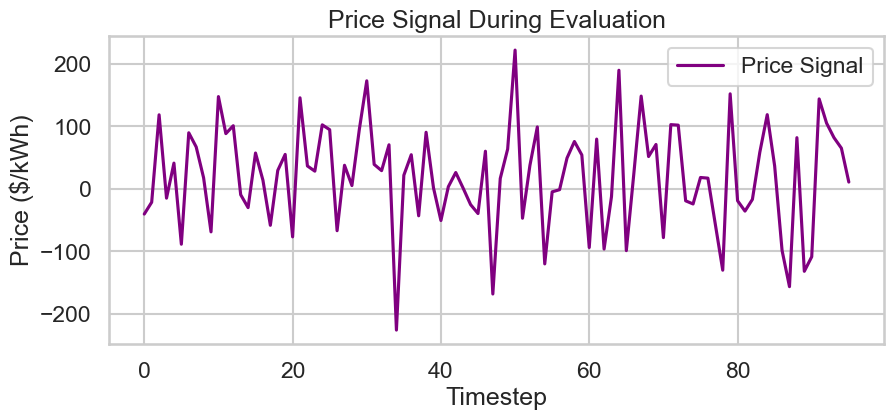

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(eval_prices, label='Price Signal', color='purple')
plt.xlabel("Timestep")
plt.ylabel("Price ($/kWh)")
plt.title("Price Signal During Evaluation")
plt.grid(True)
plt.legend()
plt.show()


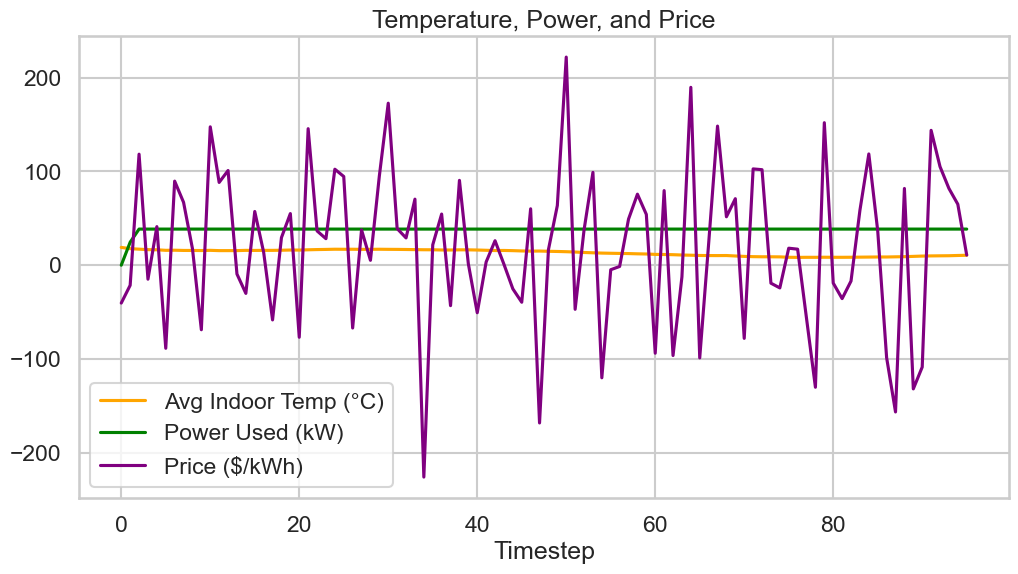

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(eval_temperatures, label='Avg Indoor Temp (°C)', color='orange')
plt.plot(eval_power_used, label='Power Used (kW)', color='green')
plt.plot(eval_prices, label='Price ($/kWh)', color='purple')
plt.xlabel("Timestep")
plt.title("Temperature, Power, and Price")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Notebook cell: density hexbin (Power vs ΔTemperature) — paste & run
# Requirements: pandas, numpy, matplotlib, seaborn
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
sns.set(style="whitegrid", context="talk")

def _ensure_datetime_index(df: pd.DataFrame, ts_col: str = "timestamp") -> pd.DataFrame:
    if ts_col in df.columns:
        df = df.copy()
        df[ts_col] = pd.to_datetime(df[ts_col])
        df = df.set_index(ts_col)
    return df

def _infer_power_series(df: pd.DataFrame):
    # heuristics to find or compute heating power
    candidates = ['heating_power', 'heating', 'heat_power', 'power', 'total_power']
    for c in candidates:
        if c in df.columns:
            return df[c].astype(float)
    if 'total_power' in df.columns and 'fixed_load' in df.columns:
        heating = df['total_power'].astype(float) - df['fixed_load'].astype(float)
        return heating.clip(lower=0.0)
    return None

def plot_density_power_vs_delta_temp(
    csv_path=None,                # path to single CSV file (preferred)
    folder_path=None,             # or path to folder with many house_*.csv
    power_col=None,               # if you know the column name, set this
    outdoor_col='outdoor_temp',
    setpoint_col='setpoint_temp',
    delta_col=None,               # optional precomputed delta column name
    gridsize=220,
    cmap='magma',
    scatter_overlay=True,
    max_scatter_points=5000,      # sample for scatter to avoid over-plotting slowdowns
    x_pct_clip=(1,99),
    y_pct_clip=(1,99),
    figsize=(10,6),
    save_path=None,
    show=True
):
    # load data
    if csv_path is None and folder_path is None:
        raise ValueError("Provide csv_path (single file) or folder_path (to read many).")
    frames = []
    if csv_path:
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"{csv_path} not found")
        df = pd.read_csv(csv_path)
        df = _ensure_datetime_index(df)
        frames.append(df)
    else:
        files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith('.csv')])
        if not files:
            raise FileNotFoundError(f"No CSV files found in folder {folder_path}")
        for f in files:
            df = pd.read_csv(f)
            df = _ensure_datetime_index(df)
            frames.append(df)
    combined = pd.concat(frames, axis=0, ignore_index=False, sort=False)

    # delta temperature
    if delta_col and delta_col in combined.columns:
        delta = combined[delta_col].astype(float).values
    else:
        if outdoor_col not in combined.columns or setpoint_col not in combined.columns:
            raise ValueError(f"Missing temperature columns. Need either '{delta_col}' or both '{outdoor_col}' and '{setpoint_col}' in the CSV(s).")
        # paper-style delta: outdoor - setpoint (negative if outside << setpoint)
        delta = (combined[outdoor_col].astype(float) - combined[setpoint_col].astype(float)).values

    # power
    if power_col:
        if power_col not in combined.columns:
            raise ValueError(f"Requested power_col '{power_col}' not found in data.")
        power = combined[power_col].astype(float).values
    else:
        inferred = _infer_power_series(combined)
        if inferred is None:
            raise ValueError("Could not infer a power column. Provide power_col or include heating_power/total_power columns in the CSV(s).")
        power = inferred.values

    # filter
    mask = np.isfinite(delta) & np.isfinite(power)
    x = delta[mask]
    y = power[mask]

    if len(x) == 0:
        raise ValueError("No valid data points after filtering NaNs.")

    # clipping for axis focus (paper focuses on central bulk)
    xmin, xmax = np.percentile(x, x_pct_clip).tolist()
    ymin, ymax = np.percentile(y, y_pct_clip).tolist()

    plt.figure(figsize=figsize)
    # hexbin with logarithmic color scaling to show core + tails
    hb = plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, mincnt=1, norm=LogNorm())
    cb = plt.colorbar(hb, pad=0.02)
    cb.set_label("counts")

    # overlay sampled scatter (to show point cloud shape) — sample if large
    if scatter_overlay:
        n = len(x)
        if n > max_scatter_points:
            idx = np.random.choice(n, max_scatter_points, replace=False)
            xs = x[idx]
            ys = y[idx]
        else:
            xs = x; ys = y
        plt.scatter(xs, ys, s=8, color='k', alpha=0.12, linewidths=0)

    plt.xlabel(r'$\Delta T$ [°C] (outdoor - setpoint)')
    plt.ylabel('Power [kW]')
    plt.title('Distribution of house heating power vs ΔTemperature')
    plt.xlim(xmin - 1.0, xmax + 1.0)
    plt.ylim(max(0.0, ymin - 0.5), ymax + 0.5)
    plt.grid(alpha=0.18)
    plt.tight_layout()
    if save_path:
        d = os.path.dirname(save_path)
        if d: os.makedirs(d, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    if show:
        plt.show()
    else:
        plt.close()

# -------------------------
# USAGE: edit file/folder below then run this cell
# Example 1: single-house CSV
csv_file = "data/synthetic/house_1.csv"        # <- change to your path or set to None
folder = None                                 # <- or set to "data/synthetic/"

plot_density_power_vs_delta_temp(
    csv_path=csv_file,
    folder_path=folder,
    power_col=None,        # set if you know exact column name e.g. "heating_power"
    outdoor_col="outdoor_temp",
    setpoint_col="setpoint_temp",
    gridsize=220,
    cmap="magma",
    scatter_overlay=True,
    max_scatter_points=5000,
    x_pct_clip=(1,99),
    y_pct_clip=(1,99),
    figsize=(10,6),
    save_path="figs/power_vs_delta_temp.png",
    show=True
)

FileNotFoundError: data/synthetic/house_1.csv not found

📉 1. Step-wise Reward During Evaluation
	•	Interpretation:
The reward starts around -2 but gradually drops to **~ -12** before recovering slightly.
	•	What this means:
	•	The PPO agent likely starts with somewhat efficient pricing, but as time progresses, either the indoor temperatures drift or power is overused, worsening comfort and cost.
	•	This is a sign of partial policy convergence, but it still struggles with maintaining consistent rewards throughout.

⸻

🌡️ 2. Average Indoor Temperature Over Time
	•	Key Observation:
Temperature drops far below the 22°C setpoint (even hitting ~8°C).
	•	Implication:
	•	The agent isn’t preserving comfort, likely undervaluing heating to save energy cost.
	•	This imbalance is driving comfort penalties and is reflected in the decreasing reward trend.

⸻

⚡ 3. Power Usage per Timestep
	•	Observation:
Constant at ~38.5 kW after timestep 1.
	•	Implication:
	•	This suggests agents are fully turning on heating and never turning off.
	•	Possibly due to poor price-to-power calibration — the agent might be ignoring price or perceiving all prices as affordable.
	•	Could indicate lack of regularization or overfitting in the actor policy.

⸻

💲 4. Price Signal During Evaluation
	•	Observation:
Prices range from -5 to 0 $/kWh, fluctuating rapidly.
	•	Implication:
	•	Prices are mostly negative, meaning the agent gets rewarded for using power, which is not realistic.
	•	Likely a bug in your price generation or negative reward scaling — prices should generally be positive or dynamic, not reward-inducing.

⸻

📊 5. Combined Plot: Temp, Power, and Price
	•	Super useful!
	•	Confirms:
	•	Power stays at maximum.
	•	Temp continuously drops.
	•	Prices are negative.
